In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
from mudpy import gmttools,view
import numpy as np

In [2]:
# # Simple 3d dot plot of fault model

# path = '/hdd/rc_fq/fall24/newfault/data/model_info/'
# fault = np.genfromtxt(path + 'largest_m7_segment.fault')

# fig = plt.figure(figsize = (10, 6), dpi = 100)
# ax = fig.add_subplot(111, projection='3d')
# p = ax.scatter(fault[:,1],fault[:,2], fault[:,3], c='blue', marker='o', s=20, lw=0, label = 'Subfaults')
# ax.view_init(azim = 75)
# plt.show()

In [3]:
def get_corners(meshfile):
    # Get subfault corners
    corners = np.genfromtxt(meshfile, usecols = range(4,13))
    i = np.where(corners[:,0] > 360)[0]
    corners[i,0] = corners[i,0] - 360
    i = np.where(corners[:,3] > 360)[0]
    corners[i,3] = corners[i,3] - 360
    i = np.where(corners[:,6] > 360)[0]
    corners[i,6] = corners[i,6] - 360
    corners[:,2] = -corners[:,2]
    corners[:,5] = -corners[:,5]
    corners[:,8] = -corners[:,8]
    return corners

In [4]:
path = '/home/sdybing/gnss-picker/data/fakequakes/'

In [5]:
meshfile = path + 'ridgecrest_M7_fault1.mshout'
# meshfile = path + 'ridgecrest_M7_fault3.mshout'

corners = get_corners(meshfile) 

rupt_name = 'newfault.000009.rupt'
# rupt_name = 'july6.000009.rupt'

rupt = np.genfromtxt('/hdd/rc_fq/fall24/newfault/output/ruptures/' + rupt_name)
# rupt = np.genfromtxt('/hdd/rc_fq/summer23/july6/output/ruptures/' + rupt_name)
print(rupt.shape)
j = np.where((rupt[:,7] != 0) & (rupt[:,8] != 0) | (rupt[:,7] != 0) & (rupt[:,9] != 0))[0]

# Figure out where the hypocenter is using only the subfaults that actually slip
slipping_rupt = rupt[j]
print(slipping_rupt.shape)

# Earliest onset time of the slipping subfaults
i = np.where(slipping_rupt[:,12] == min(slipping_rupt[:,12]))[0]
print(slipping_rupt[i])

hypo_lon = slipping_rupt[i,1]
hypo_lat = slipping_rupt[i,2]
hypo_depth = slipping_rupt[i,3]

hypocenter = np.array([hypo_lon, hypo_lat, hypo_depth])
print(hypocenter)

fault_name = '/hdd/rc_fq/fall24/newfault/output/ruptures/' + rupt_name
# fault_name = '/hdd/rc_fq/summer23/july6/output/ruptures/' + rupt_name
gmttools.make_total_model(fault_name, thresh = 0)
fault = np.genfromtxt(fault_name + '.total')



(426, 14)
(280, 14)
[[ 9.20000000e+01 -1.17568827e+02  3.57167270e+01  1.41933000e+01
   3.27770000e+02  8.75200000e+01  5.00000000e-01  4.90000000e+00
  -4.81000000e+00  5.30000000e-01  2.41039000e+03  2.41039000e+03
   0.00000000e+00  3.79691200e+10]]
[[-117.568827]
 [  35.716727]
 [  14.1933  ]]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


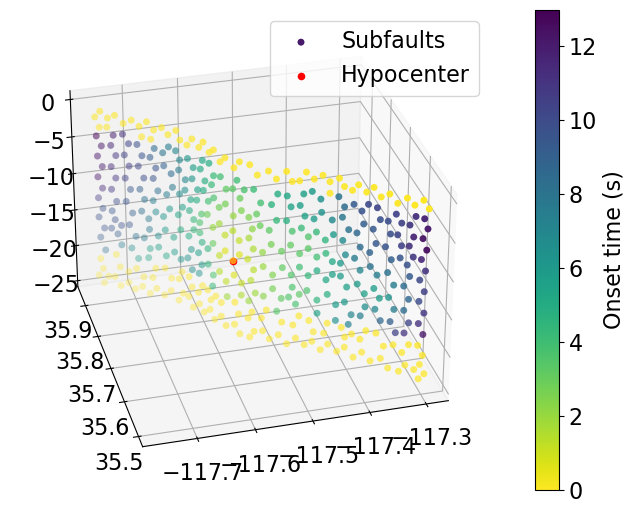

In [6]:
# Plot rupture onset on fault in 3D view

lon = rupt[:,1]
lat = rupt[:,2]
depth = -rupt[:,3]
onset = rupt[:,12]

slon = slipping_rupt[:,1]
slat = slipping_rupt[:,2]
sdepth = -slipping_rupt[:,3]
sonset = slipping_rupt[:,12]

fig = plt.figure(figsize = (10, 6), dpi = 100)
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(lon, lat, depth, c = onset, cmap = 'viridis_r', marker = 'o', s = 25, lw = 0, label = 'Subfaults')
q = ax.scatter(hypo_lon, hypo_lat, -hypo_depth, c = 'red', label = 'Hypocenter')

ax.invert_xaxis()
ax.set_ylim(ax.get_ylim()[::-1])
ax.view_init(azim = 75)

cb = fig.colorbar(p)

cb.set_label('Onset time (s)')

plt.subplots_adjust(left=0.1, bottom=0.1, right=1.0, top=0.9, wspace=0, hspace=0)
ax.legend()

plt.show()



In [7]:
# 3d fault plot with triangles

# Normalized slip
slip = (fault[:,8]**2 + fault[:,9]**2)**0.5
total_slip = slip

maxslip = None

# Saturate to max slip
if maxslip != None:
    imax = np.where(slip > maxslip)[0]
    slip[imax] = maxslip

# Normalize
norm_slip = slip / slip.max()

fig = plt.figure(figsize = (9,6), dpi = 400)
ax = fig.add_subplot(111, projection = '3d')

ax.set_title(rupt_name)

# Finagle the axis ticks
xmajorLocator = MultipleLocator(0.25) # Interval for longitude markings
ymajorLocator = MultipleLocator(0.25) # Interval for latitude markings
zmajorLocator = MultipleLocator(20) # Interval for depth markings
ax.xaxis.set_major_locator(xmajorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.zaxis.set_major_locator(zmajorLocator)
xl = [corners[:,0].min() - 0.02, corners[:,0].max() + 0.02] # Longitude extent of plot
yl = [corners[:,1].min() - 0.02, corners[:,1].max() + 0.02] # Latitude extent of plot
zl = [0, 25] # Depth extent of plot

ax.set_xlim(xl)
ax.set_ylim(yl)
ax.set_zlim(zl)
ax.set_box_aspect((1, 1, 0.45))  # Relative height of depth axis
ax.invert_zaxis()
ax.view_init(elev = 15, azim = -103) # View angle

# Patches for subfaults for each fault segment

# Colormap for slip
# slip_colormap = plt.cm.gist_heat_r
slip_colormap = plt.cm.gnuplot2_r

for ksub in range(len(corners)):
    vertices = [[tuple(corners[ksub, 0:3]), tuple(corners[ksub, 3:6]), tuple(corners[ksub, 6:9])]]
    subfault = Poly3DCollection(vertices, linewidths = 0.5)
    subfault.set_color(slip_colormap(norm_slip[ksub]))
    subfault.set_linewidth(0.5)
    subfault.set_edgecolor('#505050')
    ax.add_collection3d(subfault)

# Dummy mapable for colorbar
s = plt.scatter(np.zeros(len(total_slip)), np.zeros(len(total_slip)), c = total_slip, cmap = slip_colormap, s = 0.00001, lw = 0)

# Make colorbar
ax_cb2 = fig.add_axes([0.85, 0.28, 0.03, 0.5]) # x, y, width, height
cb = plt.colorbar(s, cax = ax_cb2)
tick_locator = ticker.MaxNLocator(nbins = 5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label('Slip (m)', fontsize = 15)

# Labels n' stuff
ax.set_xlabel('\n\nLongitude', fontsize = 15)
ax.set_ylabel('\n\nLatitude', fontsize = 15)
ax.set_zlabel('\nDepth\n(km)', fontsize = 15, rotation = 90)

plt.subplots_adjust(bottom = 0, top = 1.1, left = 0, right = 0.99)

# plt.show()

# plt.savefig('/home/sdybing/gnss-picker/manuscript_figures/3d_fault_mesh_example.jpg', format = 'JPG')
plt.savefig('/home/sdybing/gnss-picker/manuscript_figures/Figure2.png', format = 'PNG')
plt.close()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
